In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = (12,6)

import os
import torch

import numpy as np
import pandas as pd
import seaborn as sns

from torchvision.datasets import MNIST
from torchvision import transforms

from spiking import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define the network
net = SpikingLGN(num_retina_layers=1, num_lgn_layers=1, num_neurons_retina=1500, num_neurons_lgn=400,
                 square_size=28, num_classes=10, neighbourhood_size=(3, 5), num_timesteps=1200, device=device)

In [4]:
# Define a random input
# inp = torch.rand((1, 1, 28, 28))

In [5]:
# Load the image from the MNIST dataset
train_dataset = MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
inp = train_dataset[0][0][None, :, :, :]  # Returns a tuple
print(inp.shape)

torch.Size([1, 1, 28, 28])


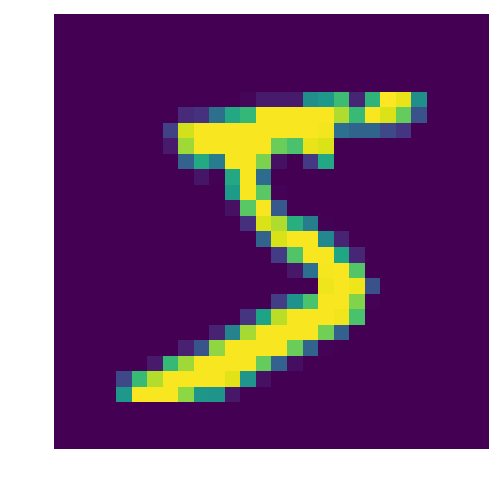

In [6]:
plt.axis('off')
plt.imshow(inp.cpu()[0, 0])

In [7]:
# Move everything to the desired device
net = net.to(device)
inp = inp.to(device)

In [8]:
# Forward prop through the network
out = net(inp)

(1200, 1500) 0.036869444


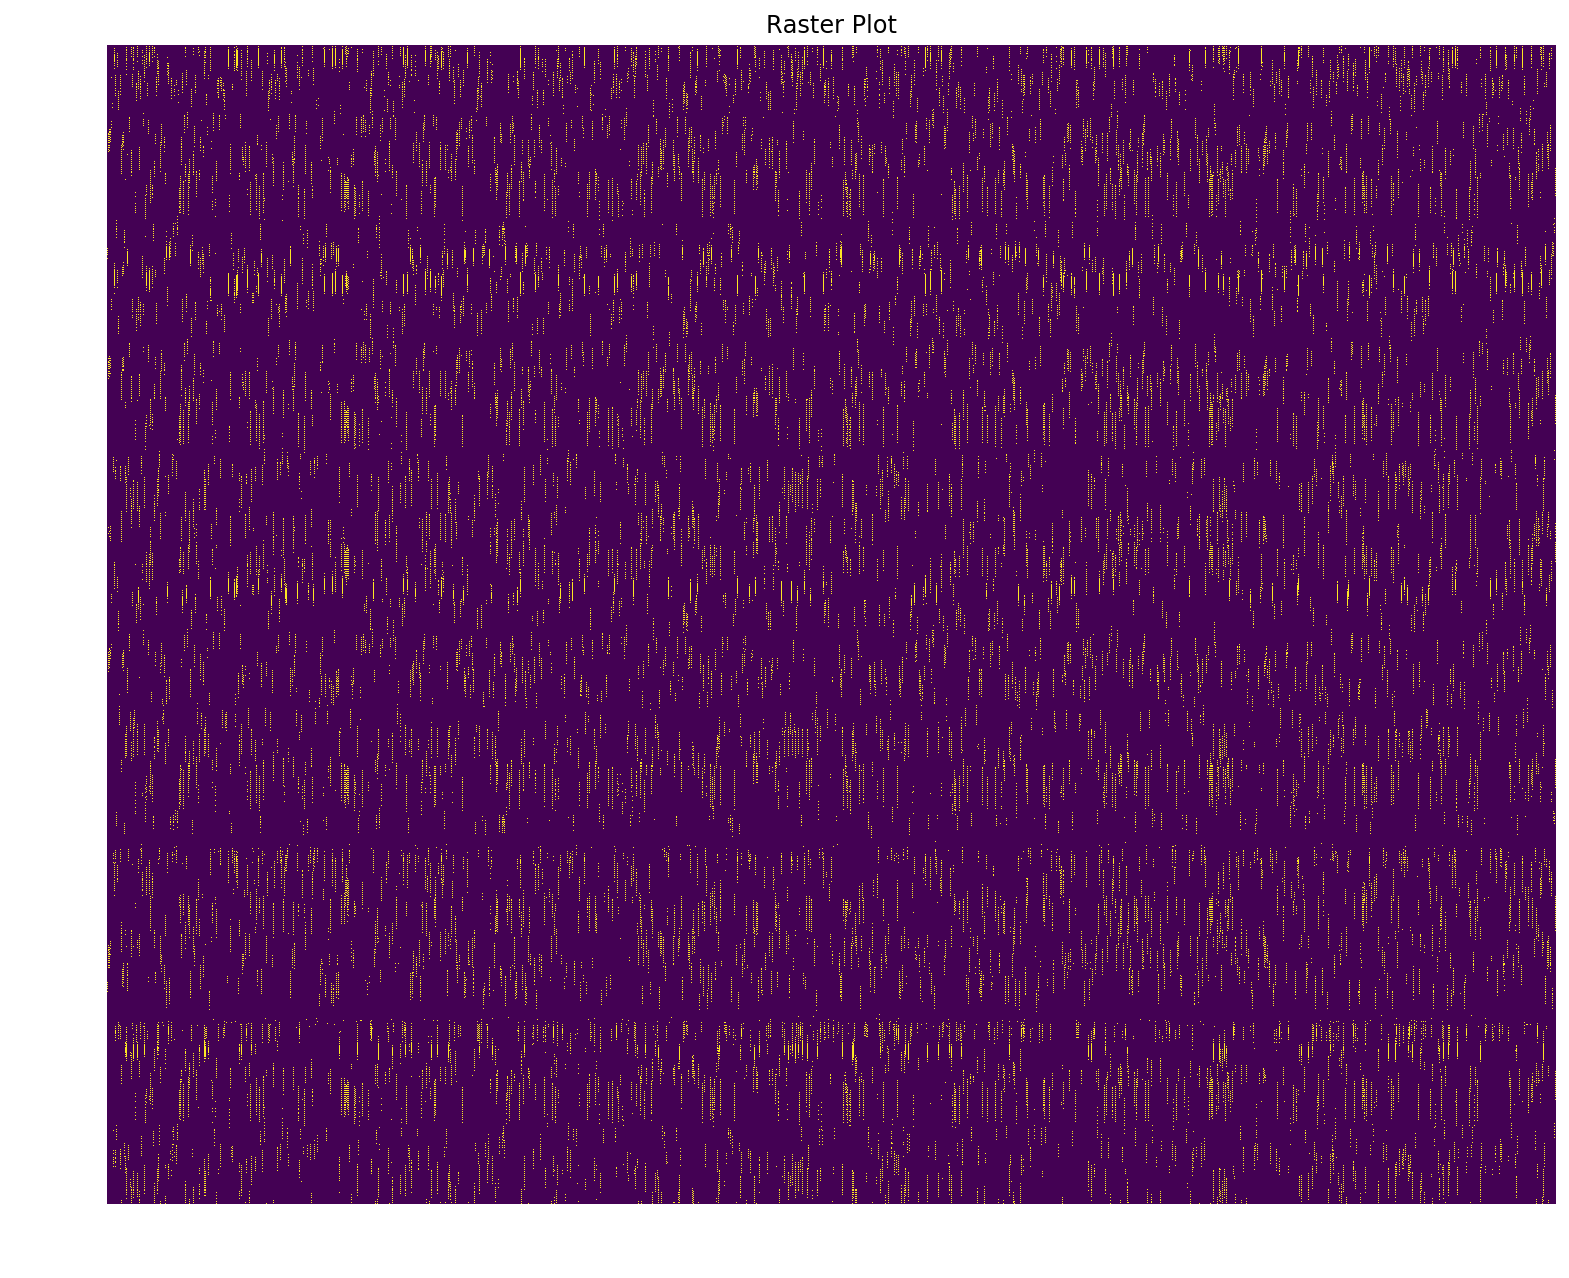

In [9]:
plt.figure(figsize=(18,9))
out = np.array(out)
print(out.shape, np.mean(out))
plt.imshow(out)
plt.title('Raster Plot')
plt.xlabel('Neuron ID')
plt.ylabel('Activation over time')
plt.tight_layout()
plt.savefig('activation.png')

In [10]:
l = net.layer[0]
vs = [n.v for n in l.nodes]
# print(vs)

In [11]:
for n in net.layer[0].nodes:
    if np.isnan(n.v.item()):
        print("breaking")
        break

In [12]:
l = net.layer[0]
vs = [n.v for n in l.nodes]
for idx, v in enumerate(vs):
    if v > 30.0:
        print(idx)

27.68672


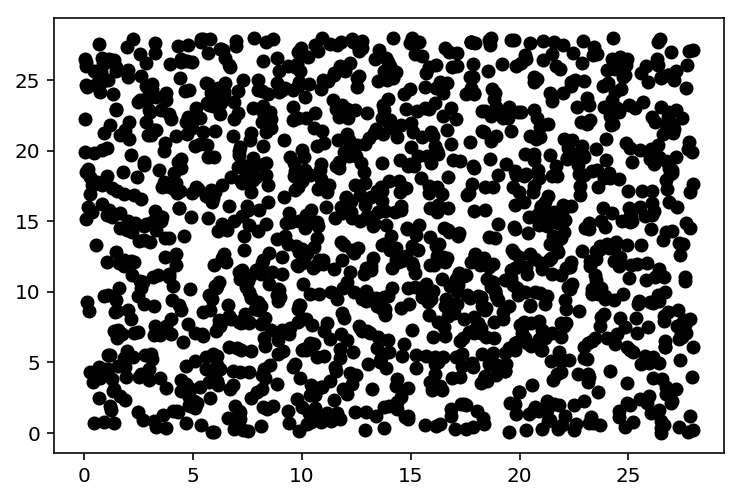

In [14]:
fig = plt.figure();

# plot all nodes in square
posMat = np.zeros([1500,2]);
allNodePos = [n.pos.cpu().numpy() for n in l.nodes];

print(allNodePos[0][1])

for i in range(len(allNodePos)):
    posMat[i,0] = allNodePos[i][0];
    posMat[i,1] = allNodePos[i][1];
    
plt.scatter(posMat[:,0], posMat[:,1],color='k')

<Figure size 432x288 with 0 Axes>

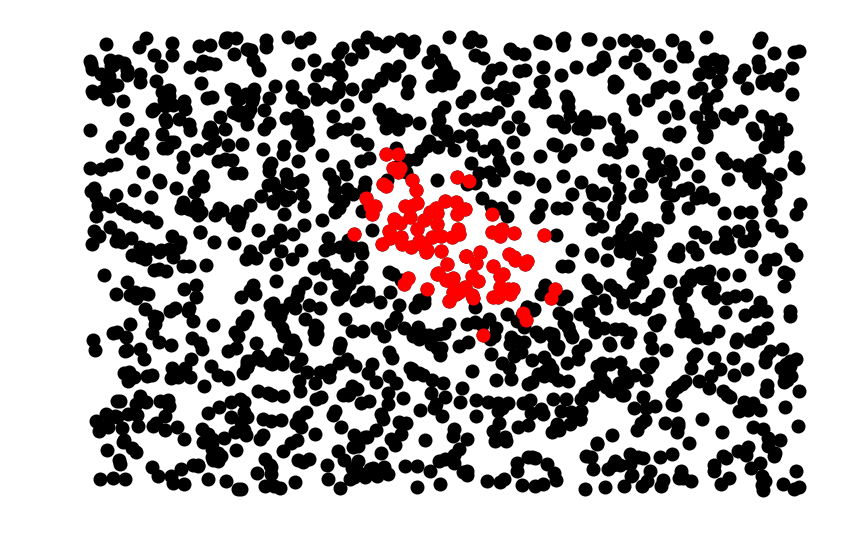

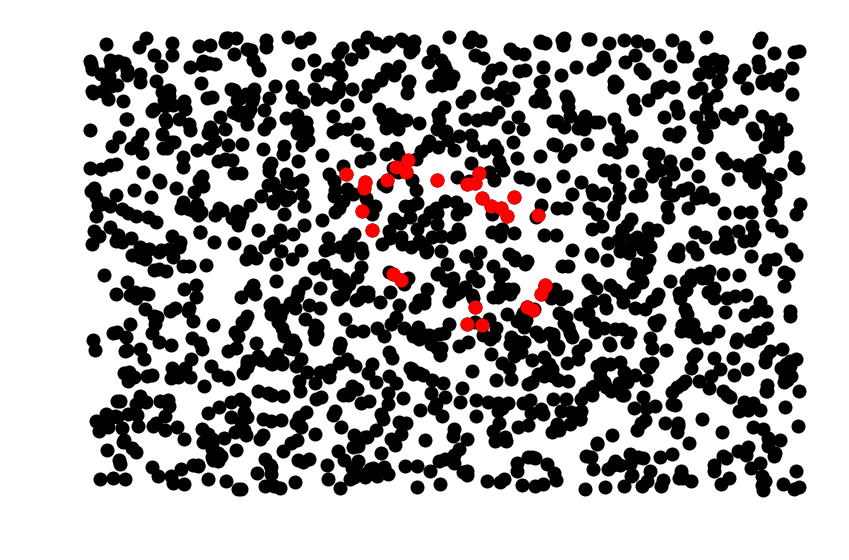

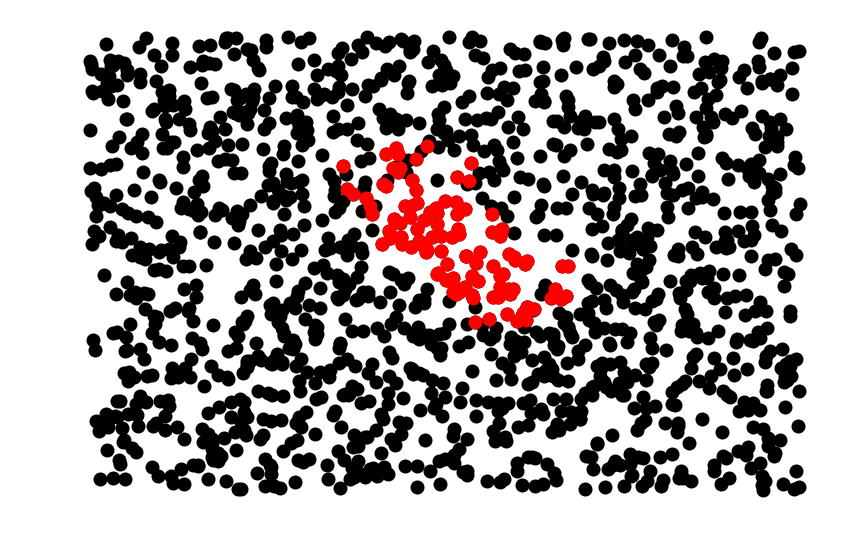

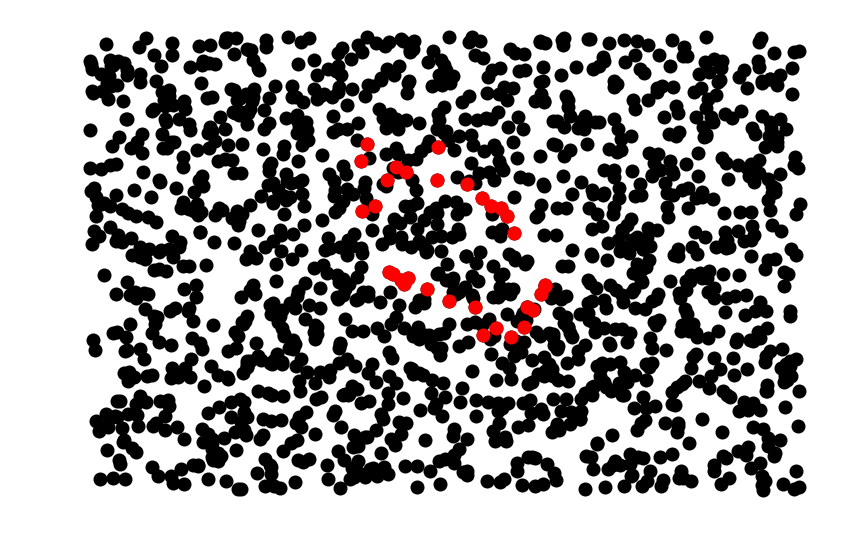

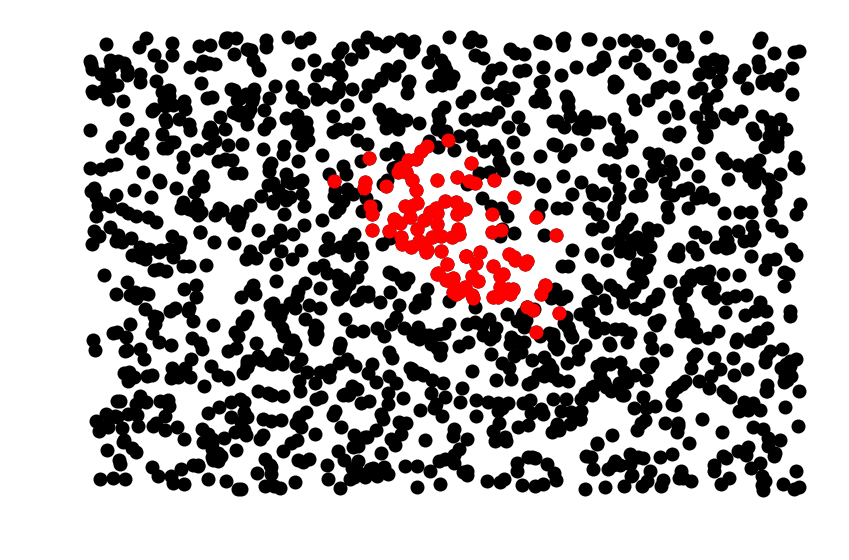

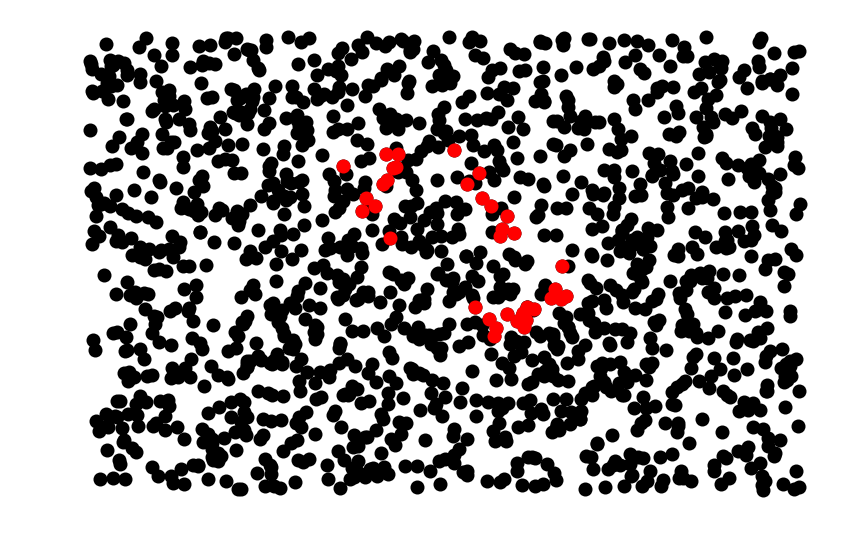

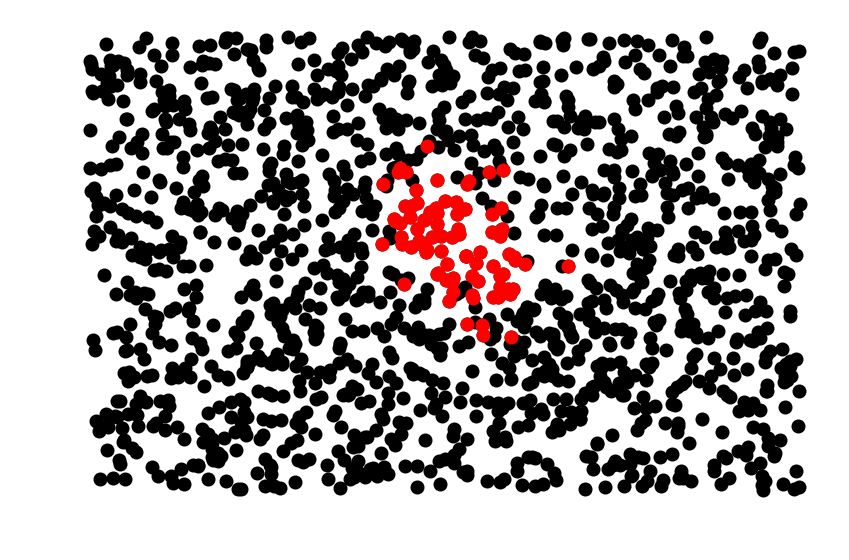

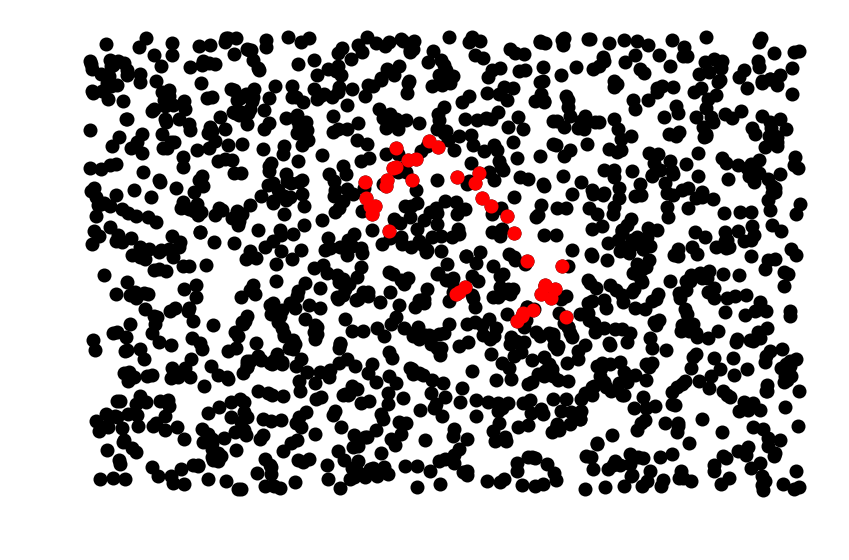

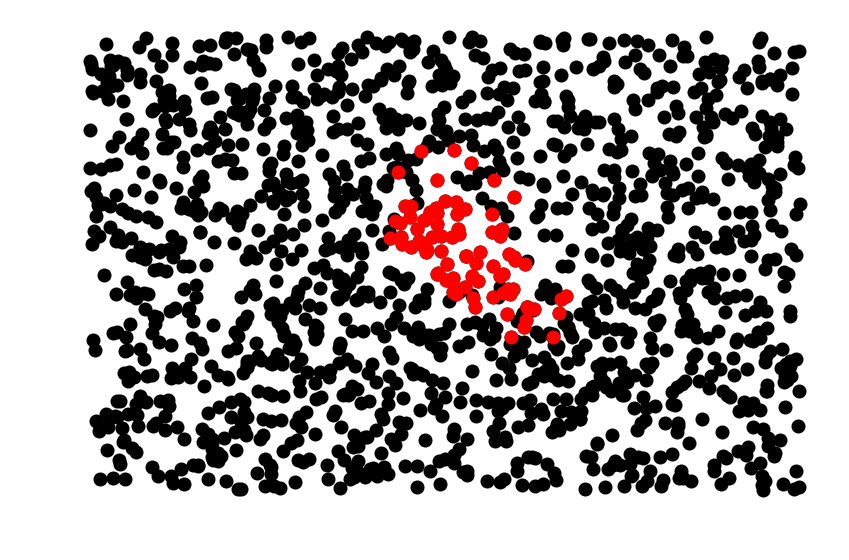

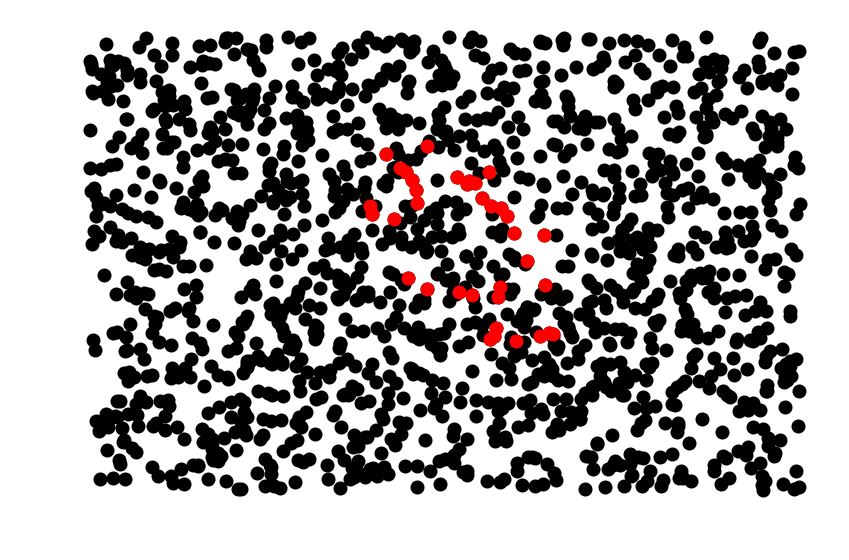

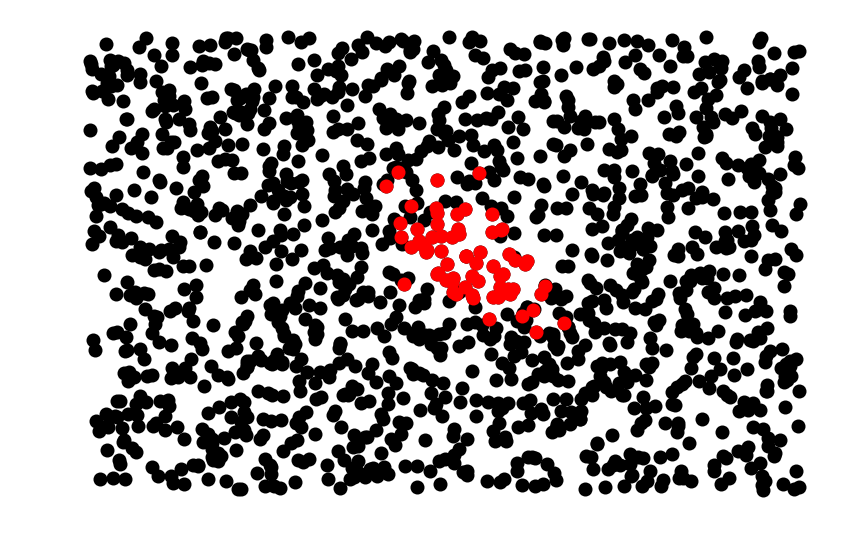

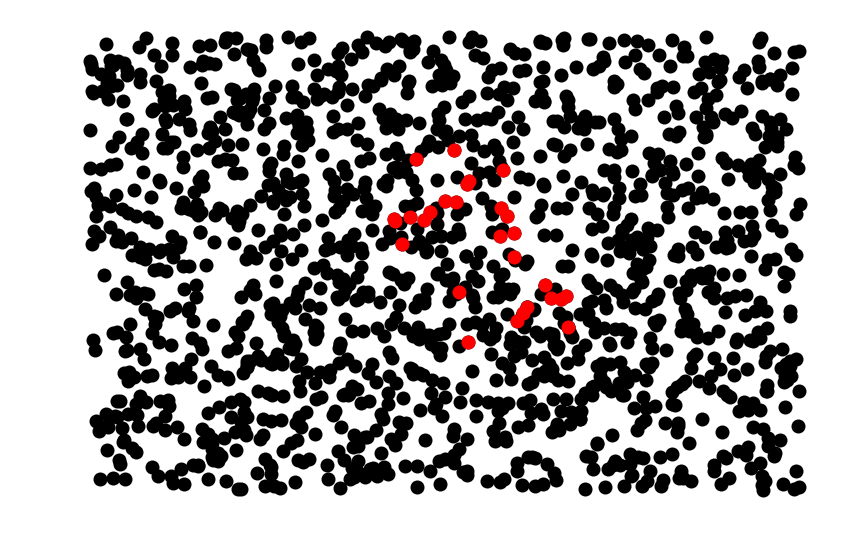

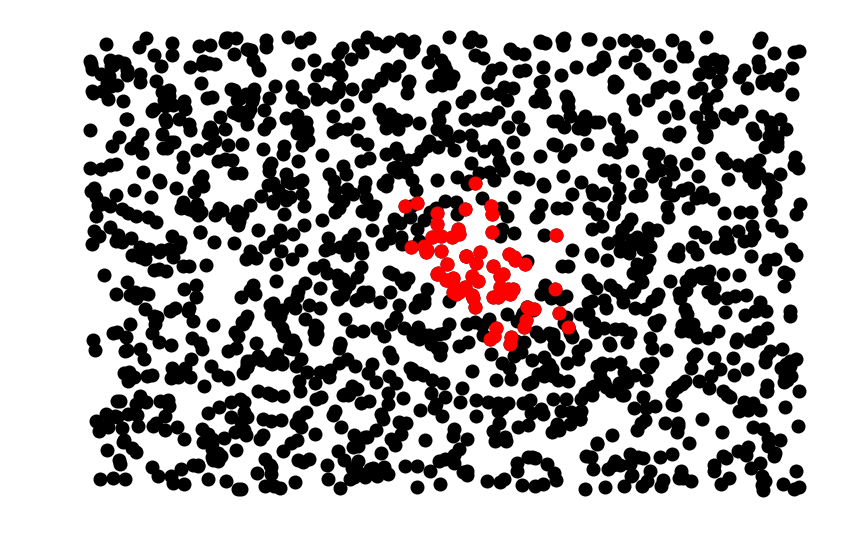

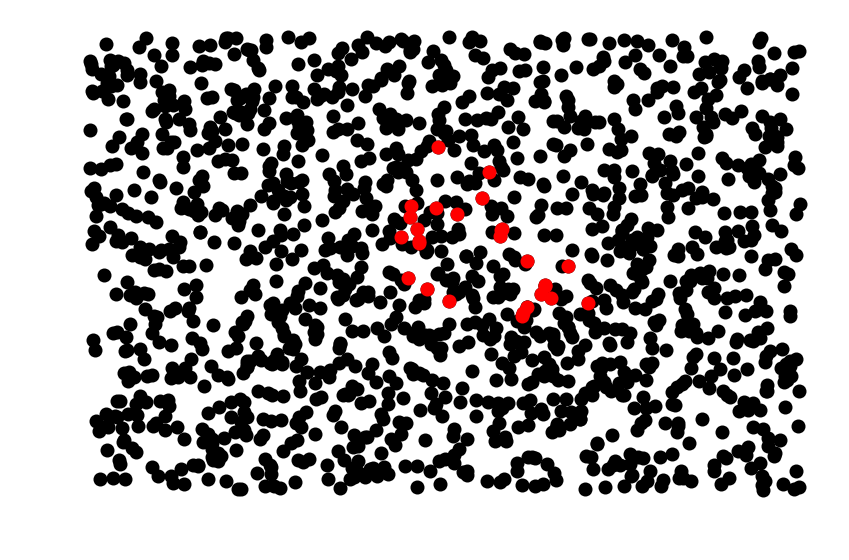

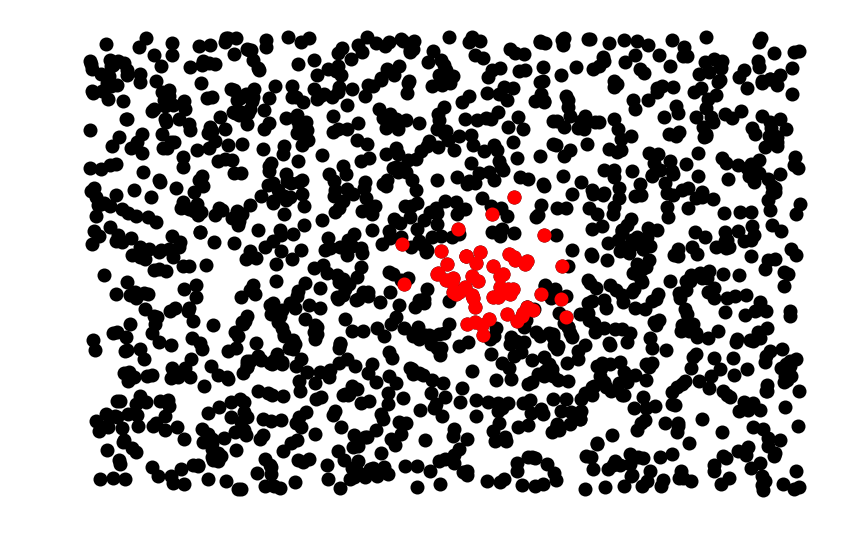

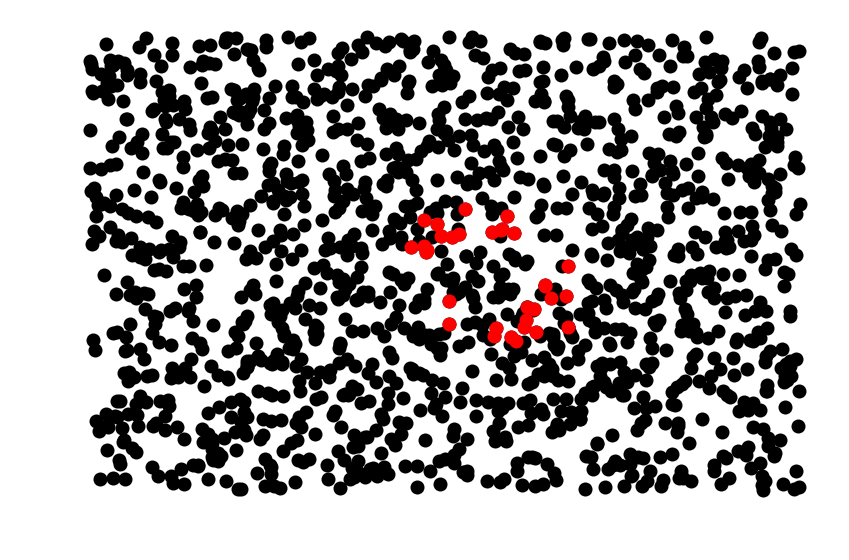

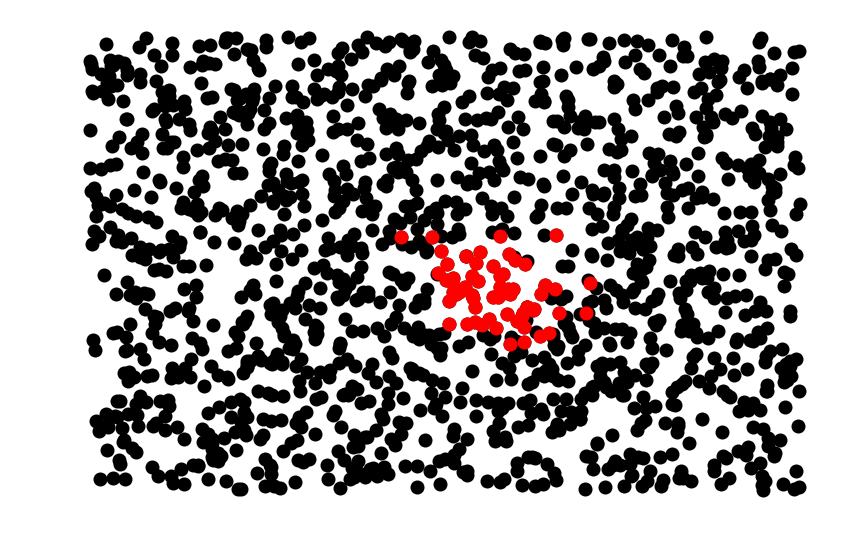

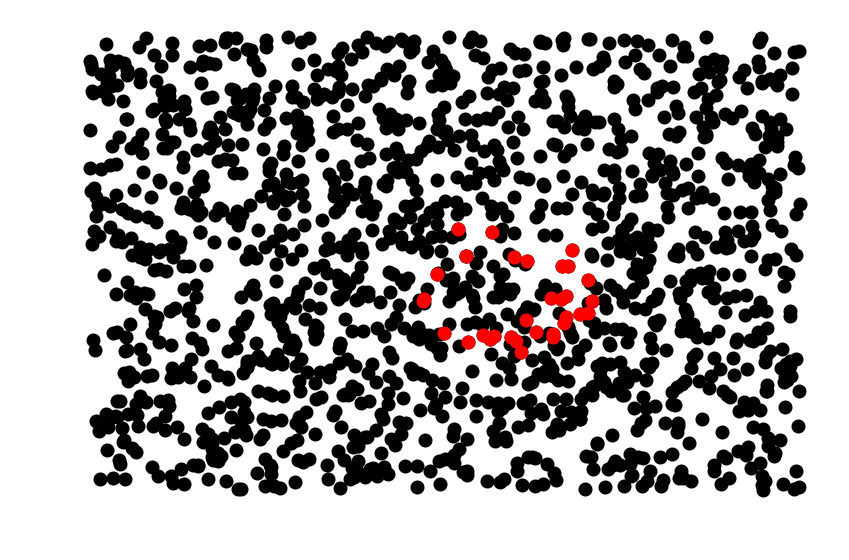

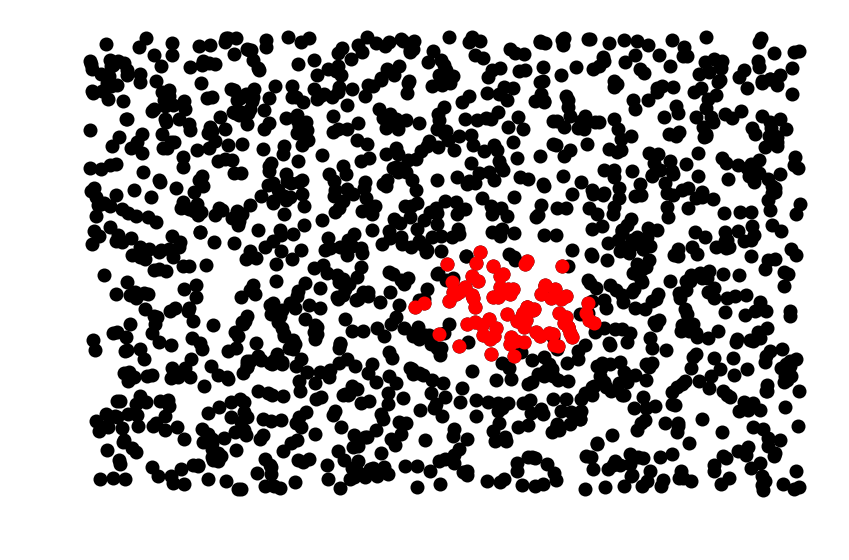

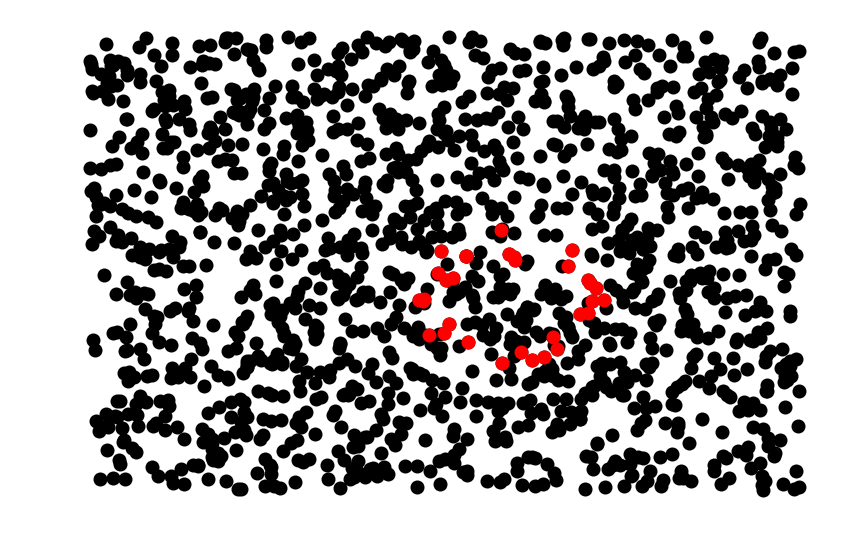

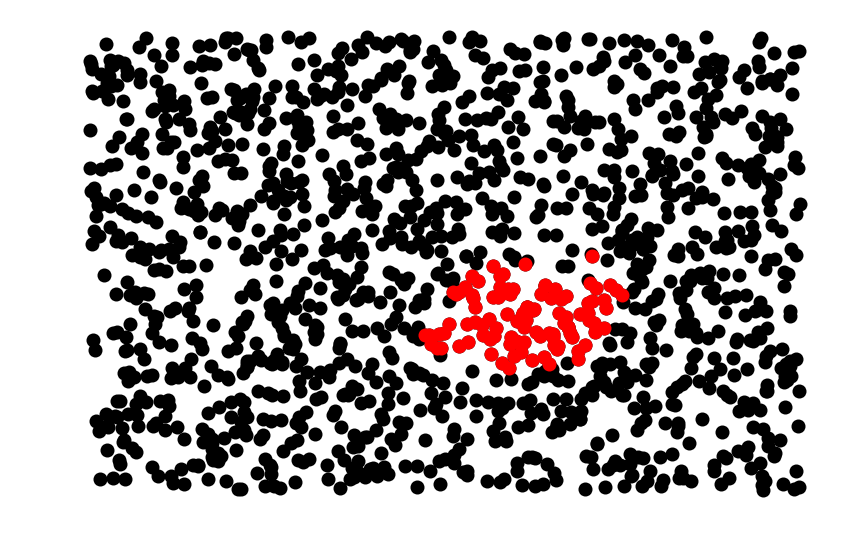

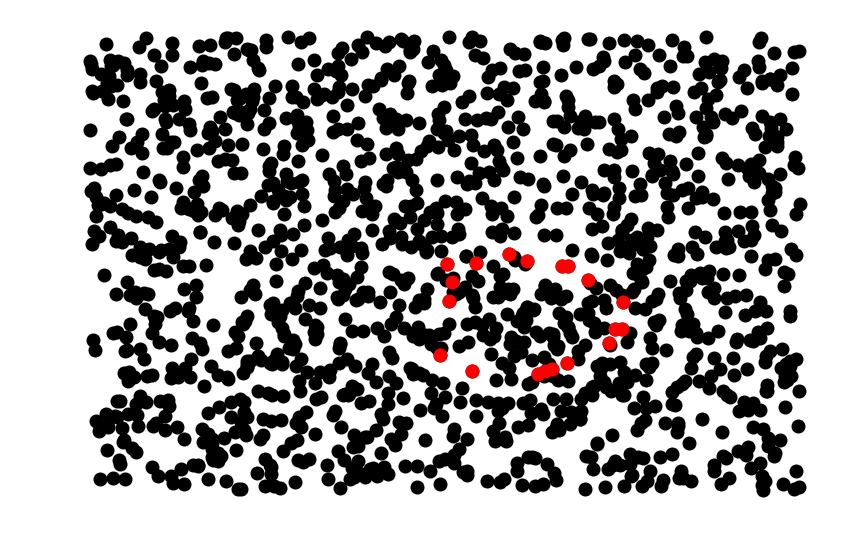

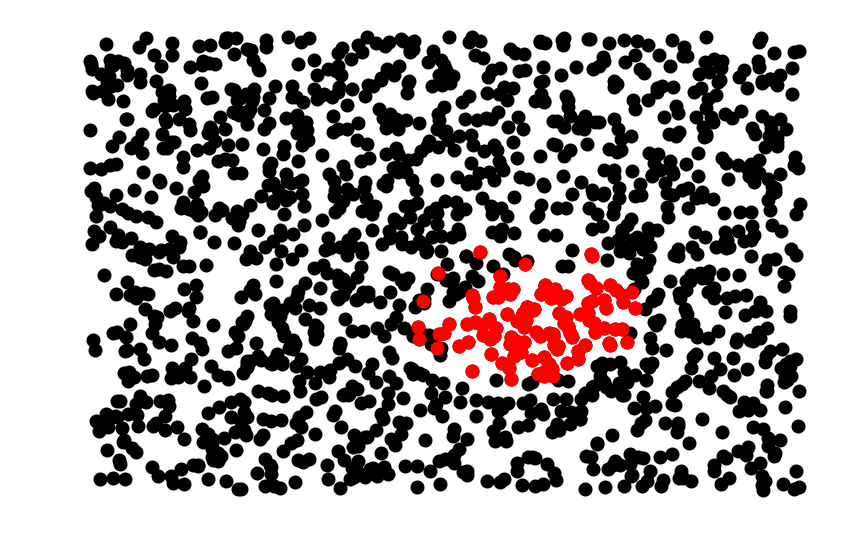

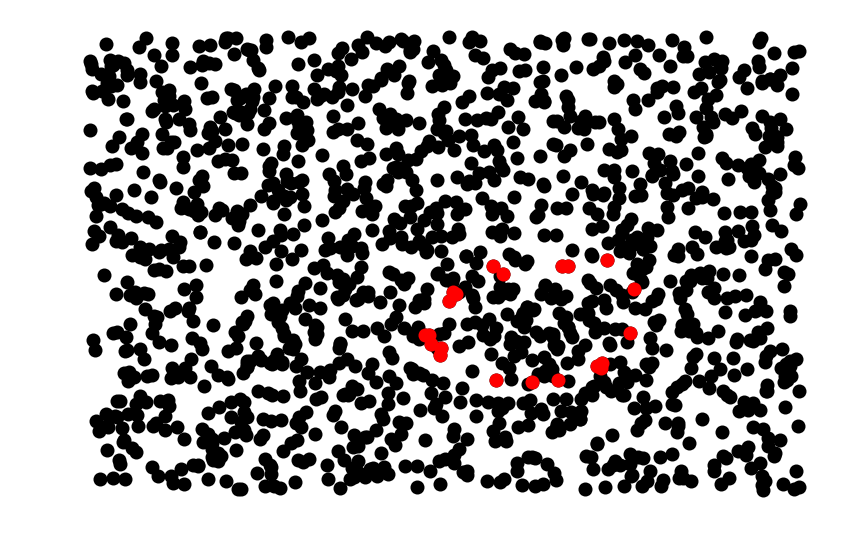

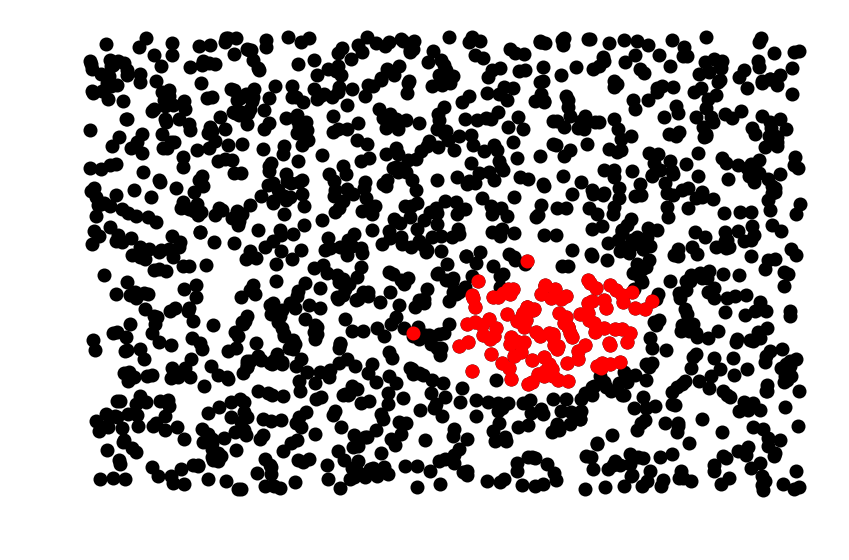

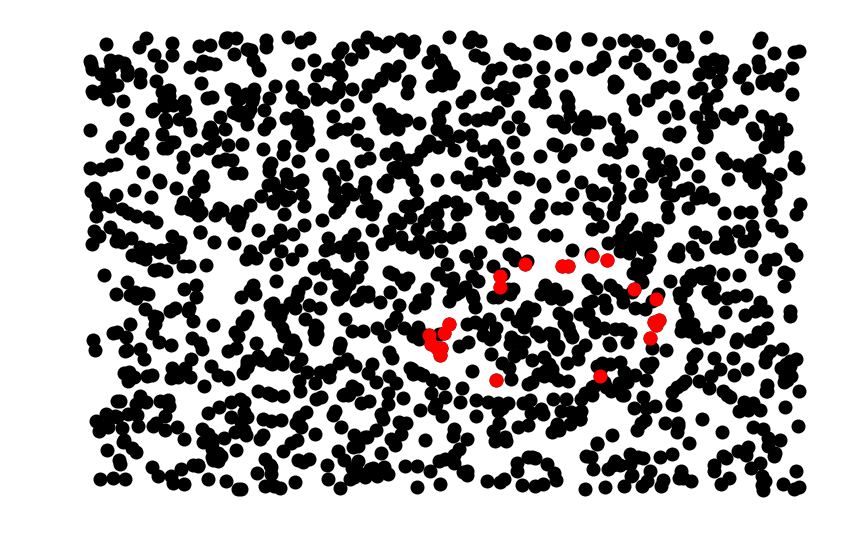

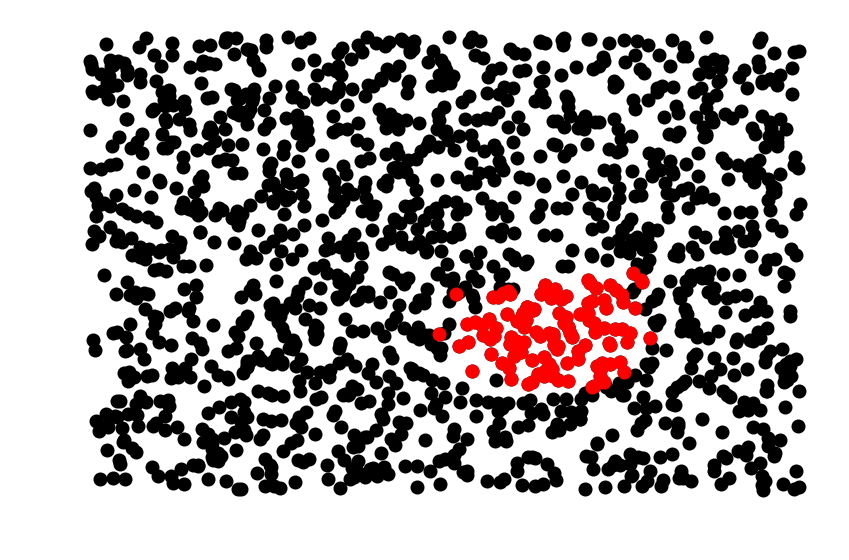

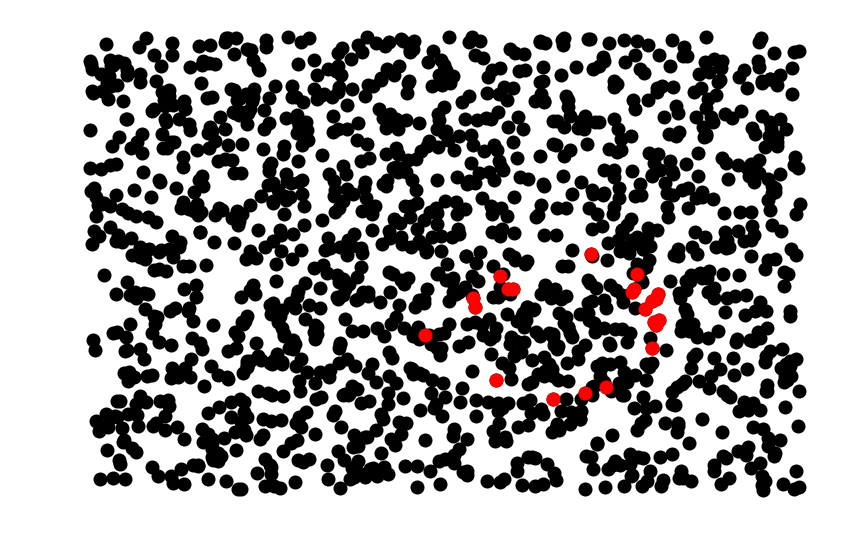

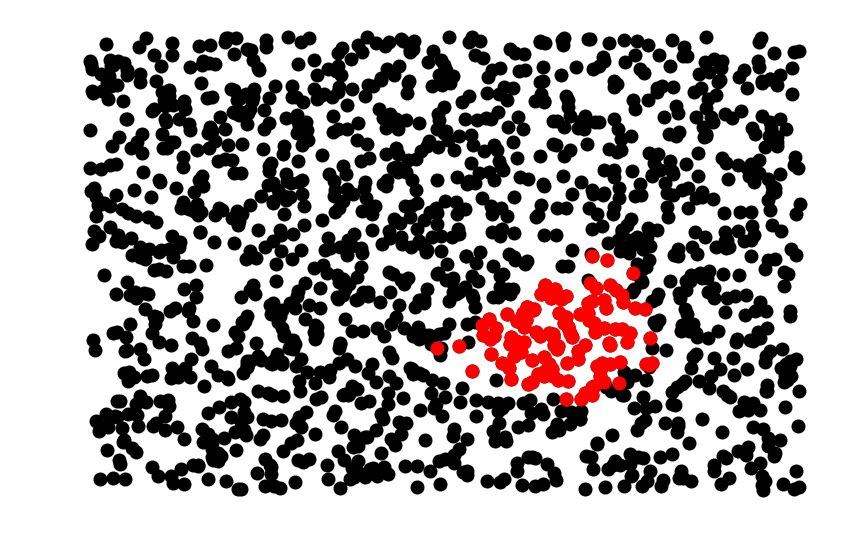

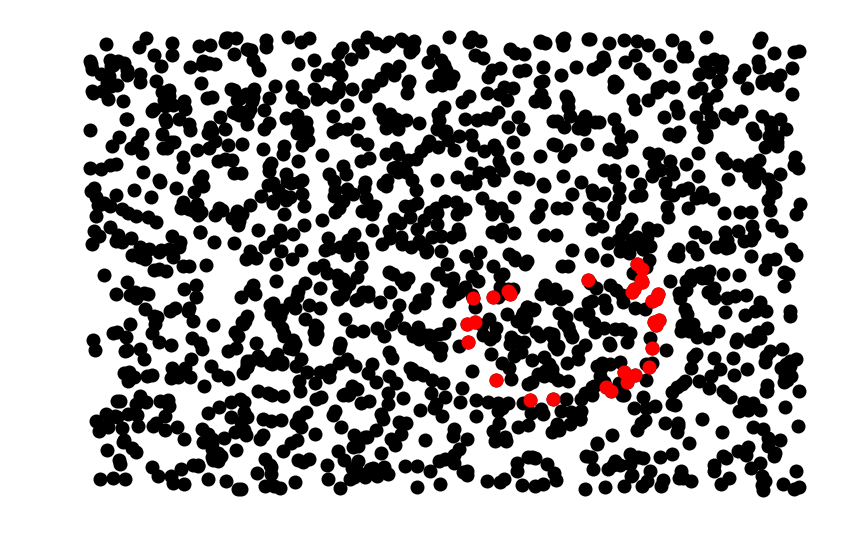

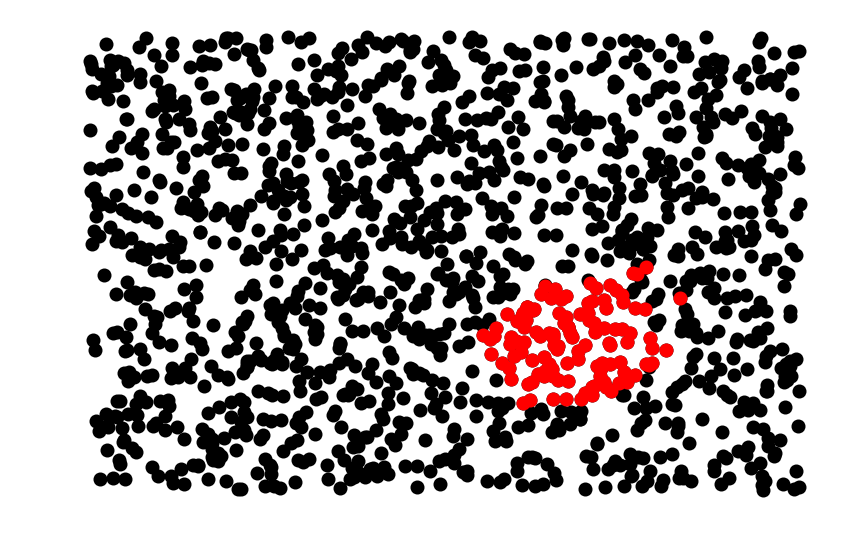

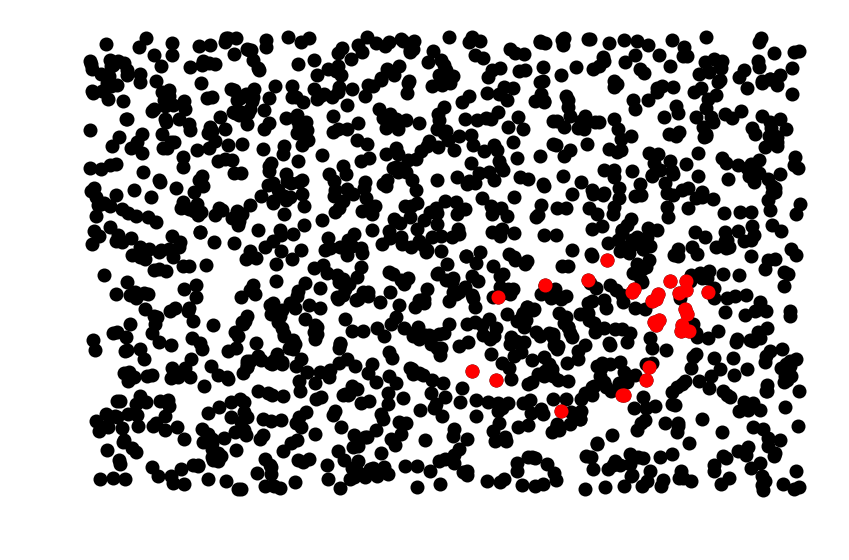

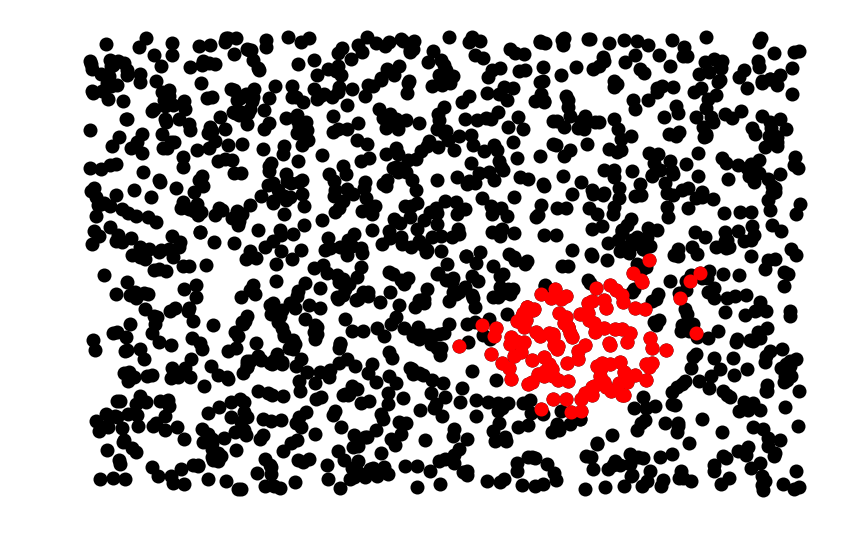

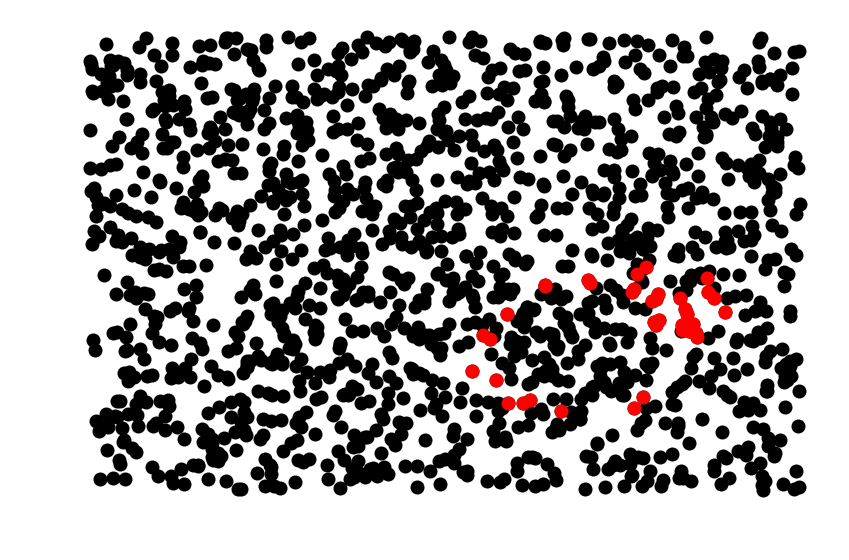

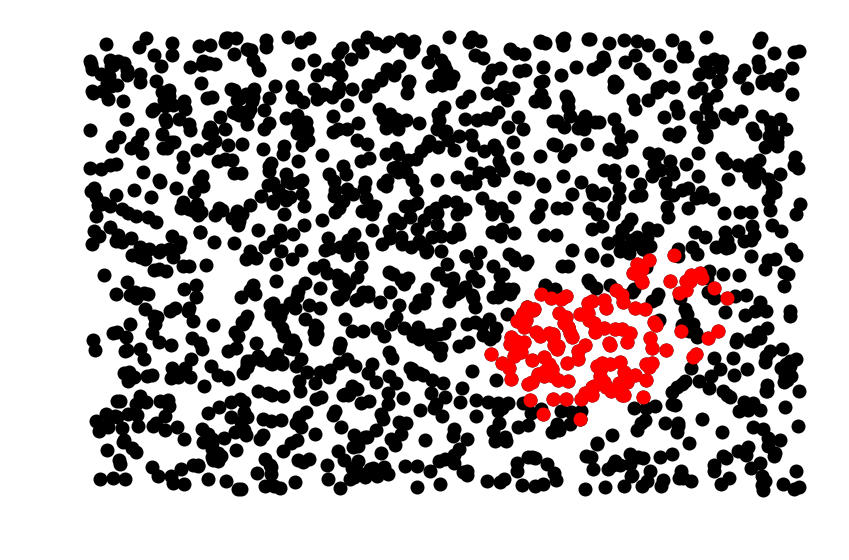

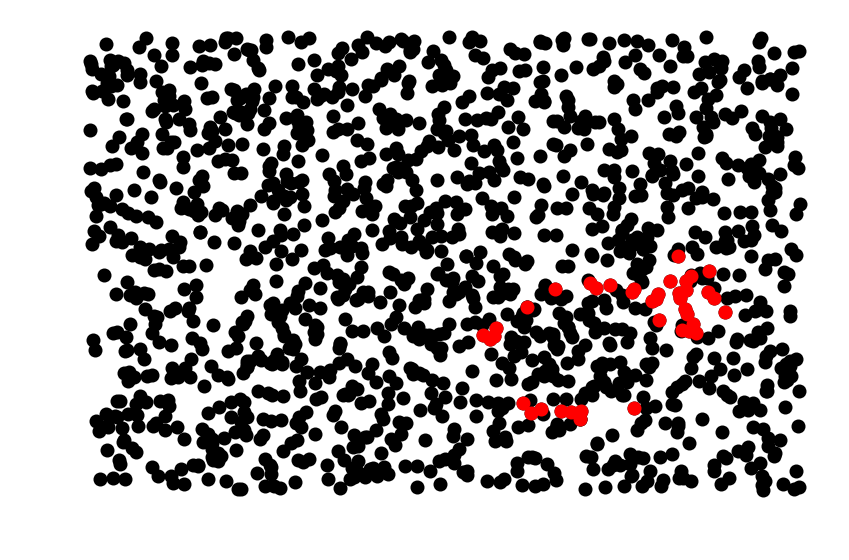

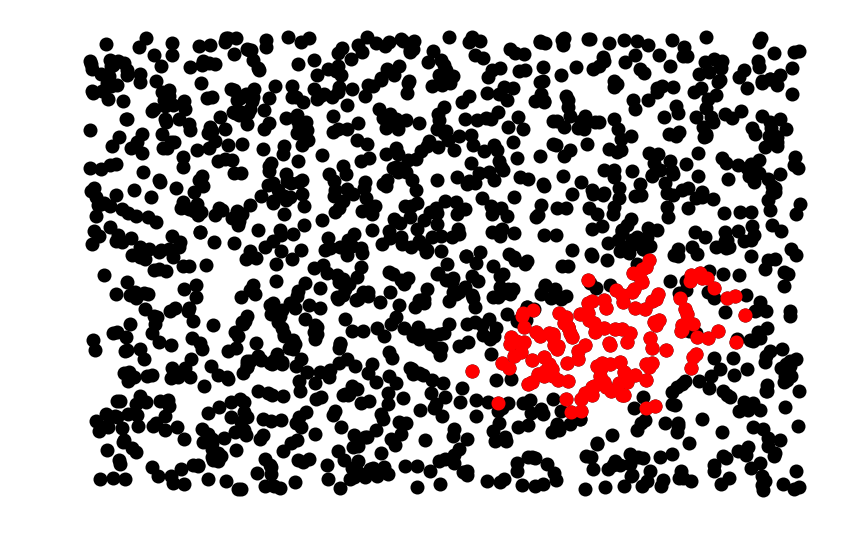

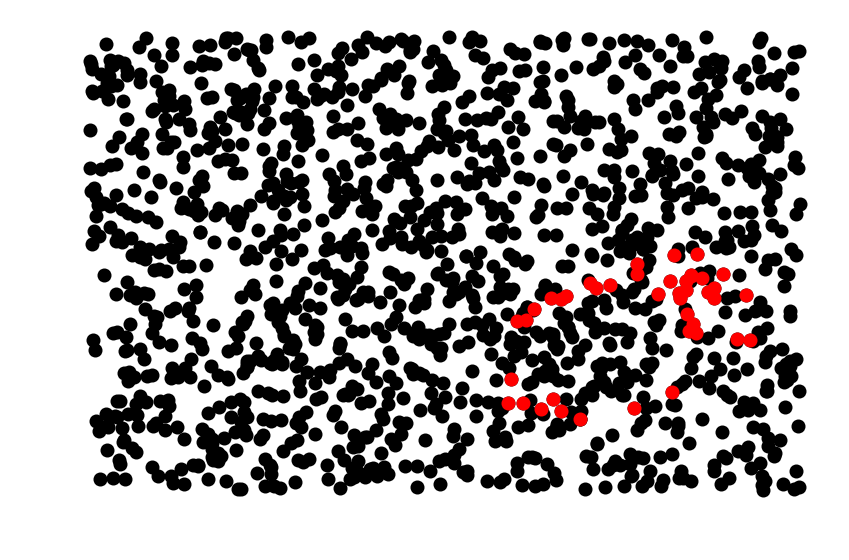

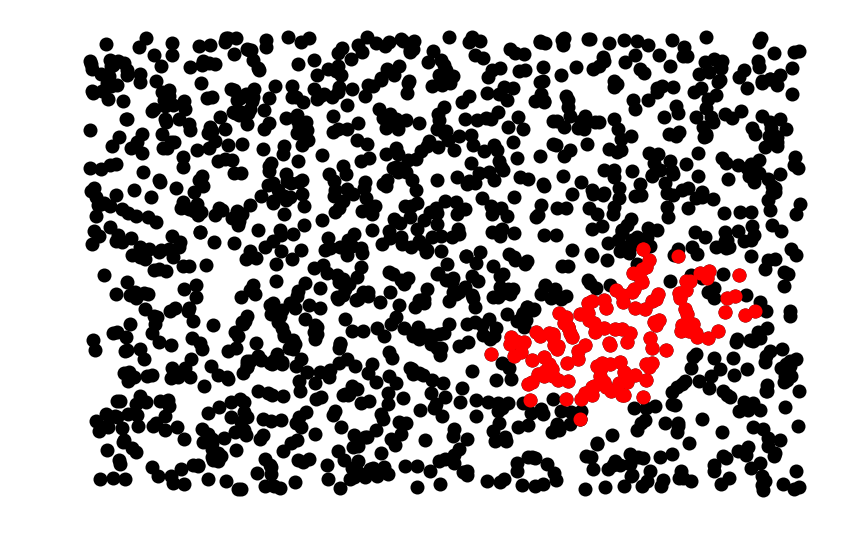

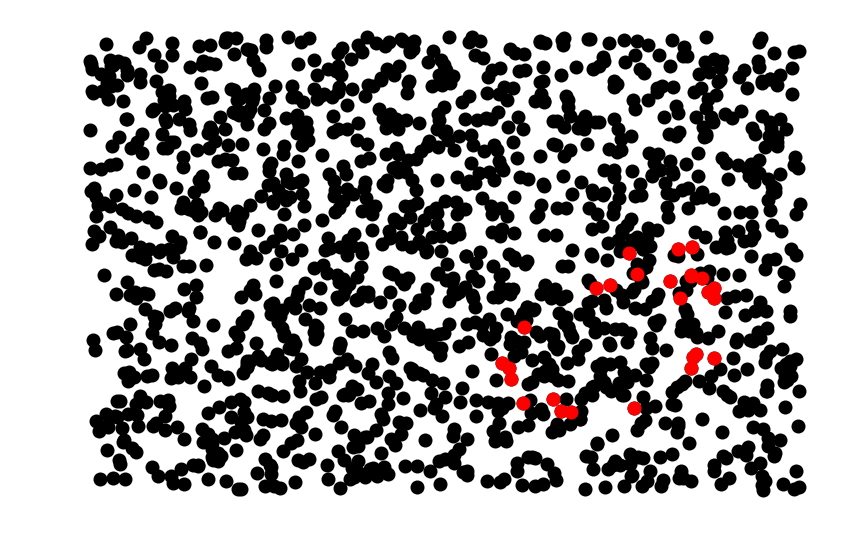

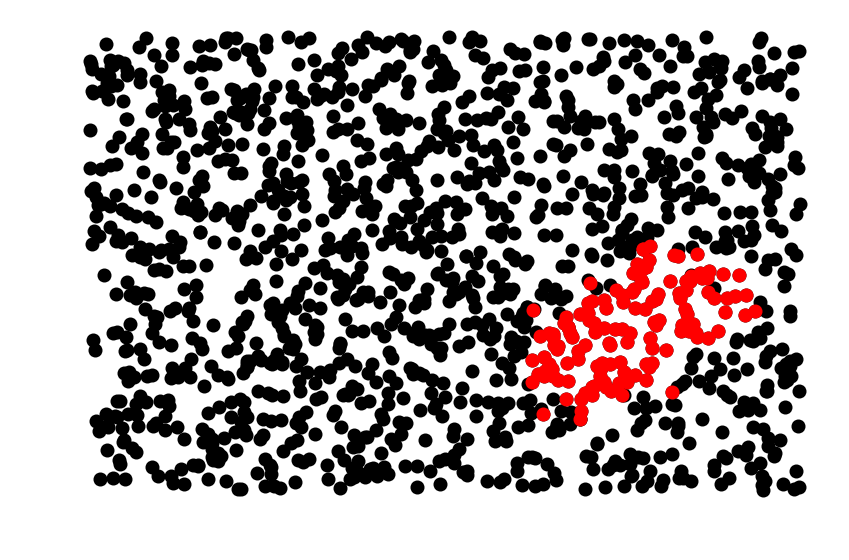

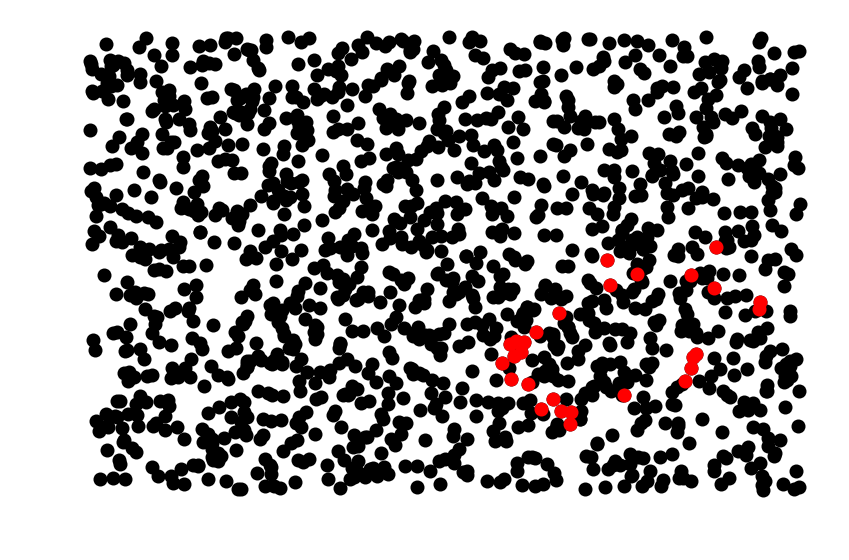

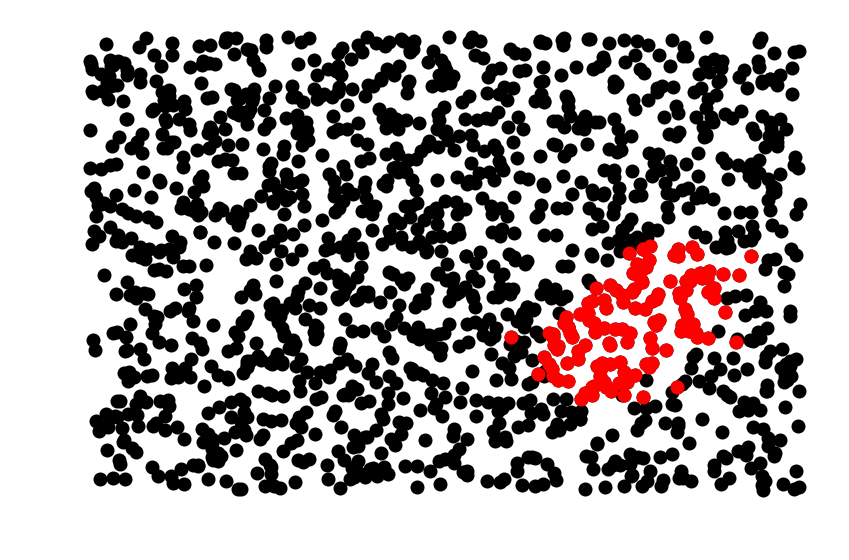

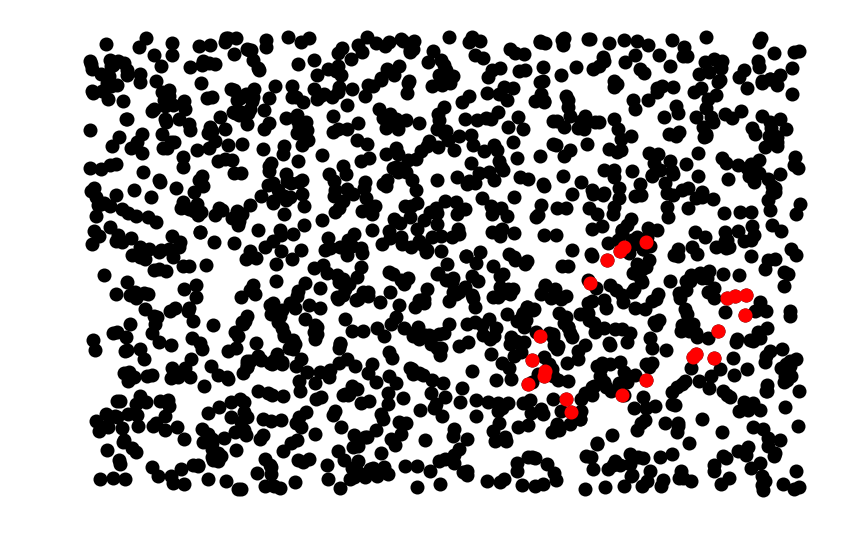

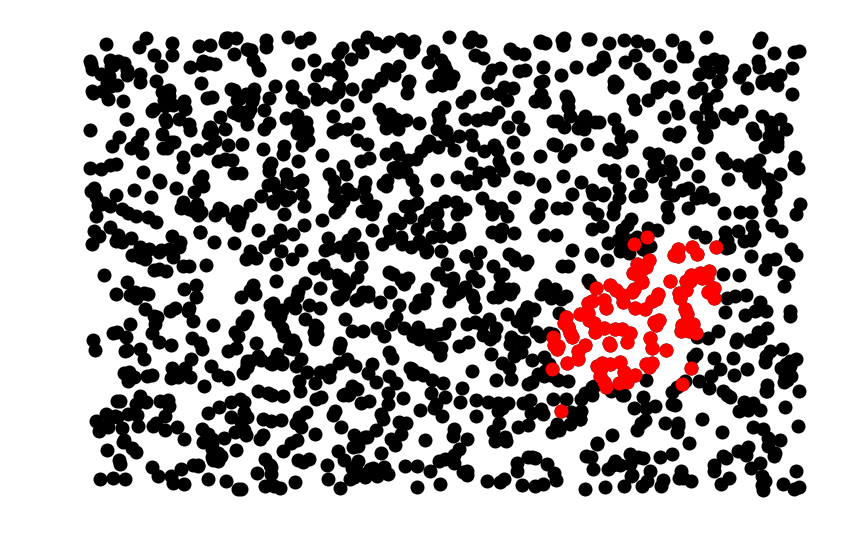

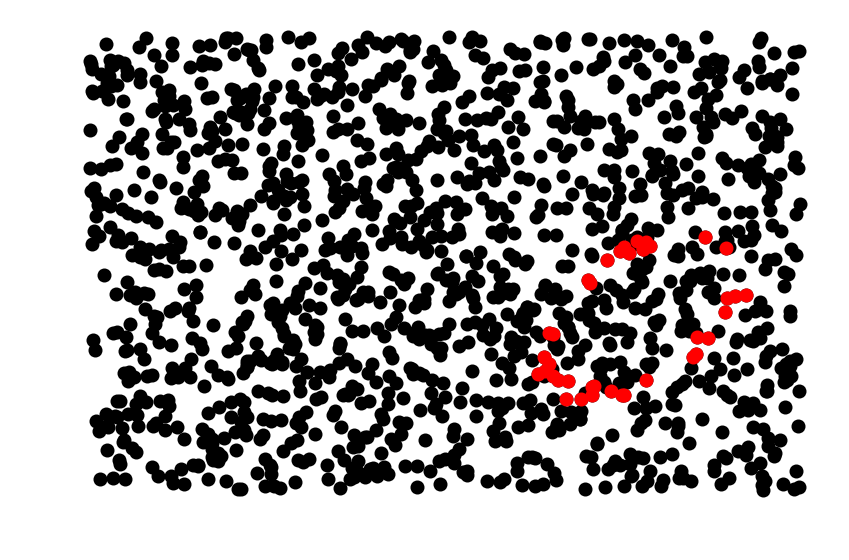

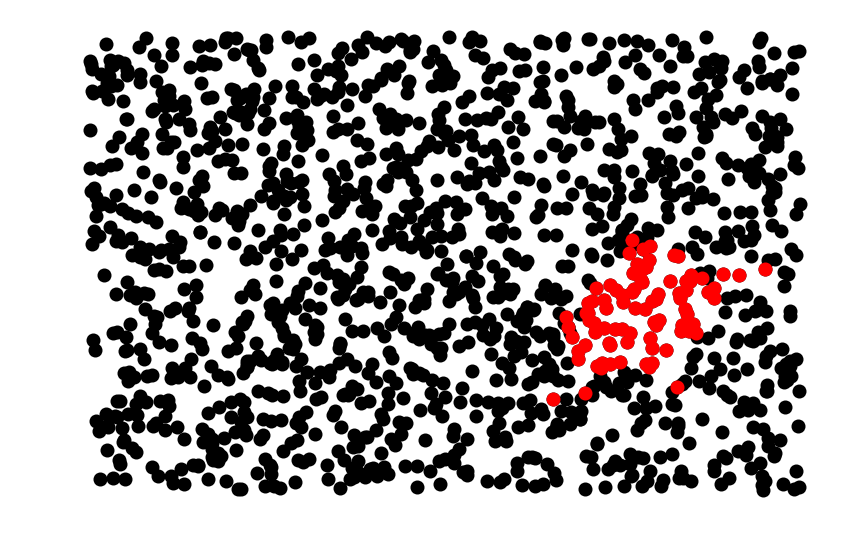

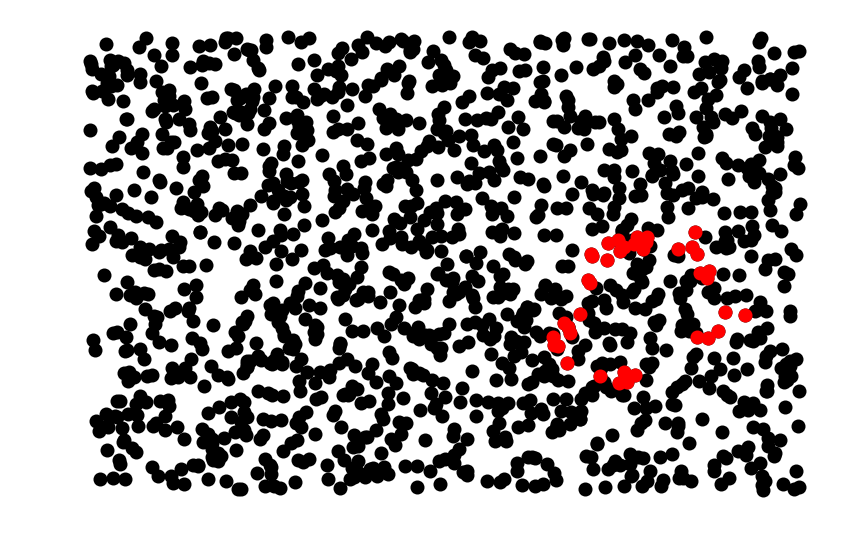

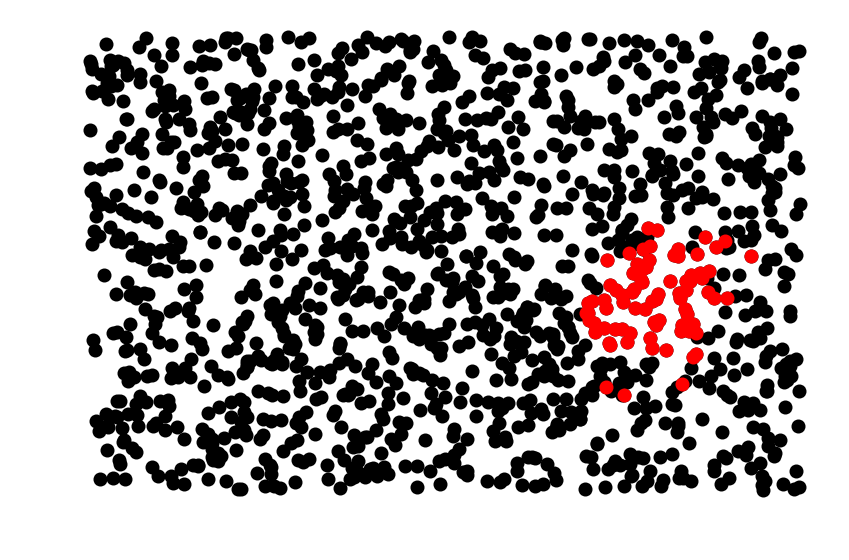

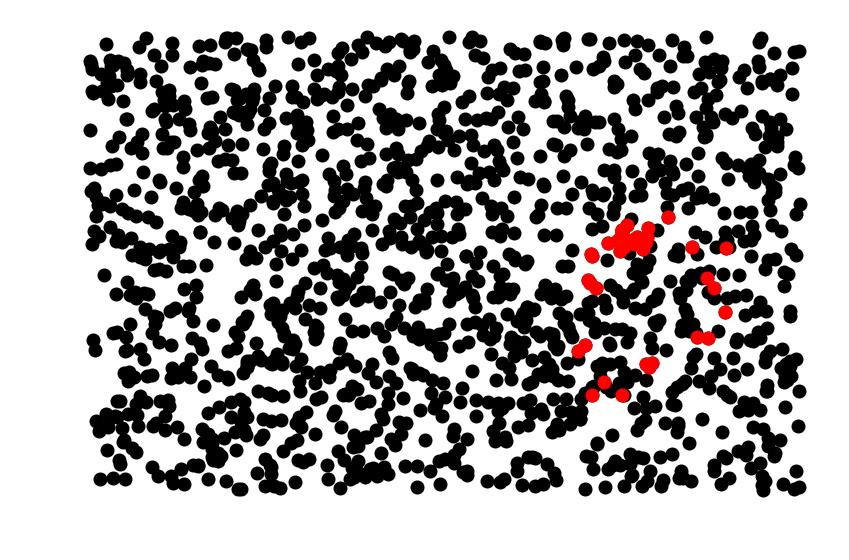

In [18]:
l = net.layer[0]
fig = plt.figure()

output_dir = 'frames'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Plot all values
for i in range(0, out.shape[0], 1):
    # Find spiking nodes at t=i
    plt.figure()
    idx = np.argwhere(out[i, :] == 1)
    flat_idx = [item for sublist in idx for item in sublist]
    pos_firing = np.zeros([len(idx), 2])
    
    ctr = 0;
    for j in flat_idx:
        tNode = l.nodes[j]
        pos2 = tNode.pos.cpu().numpy()
        pos_firing[ctr,0] = pos2[0]
        pos_firing[ctr,1] = pos2[1]
        ctr += 1
    
    plt.scatter(posMat[:,0], posMat[:,1],color='k')
    plt.scatter(pos_firing[:,0], pos_firing[:,1],color='r')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{i}.png')
    
    if 500 < i <= 550:
        plt.show()
    
    plt.close()

In [ ]:
# Convert the frames to a GIF
# !convert -resize 640x360 -delay 20 -loop 0 frames/{0..999}.png out.gif